## 1. Loading the preprocessed Data

In [1]:
import pandas as pd
import ast

# Load the saved CSV file
subjects_df = pd.read_csv('./outputs/filtered_subjects_df.csv')
subjects_df['features_value'] = subjects_df['features_value'].apply(ast.literal_eval)

# Display the first few rows to verify
subjects_df.head()


,id,ASD,SITE_ID,SEX,AGE_AT_SCAN,atlas,graph_feature_type,feature,feature_engineering,features_value,test
0,51154,0,NYU,1,30.08,cc200,node_based,degree,original,"[15, 11, 6, 2, 7, 11, 6, 9, 0, 1, 7, 8, 4, 1, ...",0
1,50617,1,YALE,1,7.25,cc200,node_based,degree,original,"[22, 5, 5, 8, 14, 7, 12, 1, 3, 3, 11, 6, 8, 6,...",1
2,50807,1,KKI,1,10.65,cc200,node_based,degree,original,"[10, 15, 4, 15, 3, 7, 11, 5, 1, 2, 2, 12, 17, ...",0
3,51369,0,MAX_MUN,1,32.00,cc200,node_based,degree,original,"[3, 40, 29, 2, 15, 4, 10, 11, 0, 0, 6, 8, 22, ...",0
4,50135,1,OLIN,1,12.00,cc200,node_based,degree,original,"[18, 31, 23, 11, 8, 56, 45, 21, 7, 2, 3, 5, 44...",0


In [2]:
subjects_df.shape

(37260, 11)

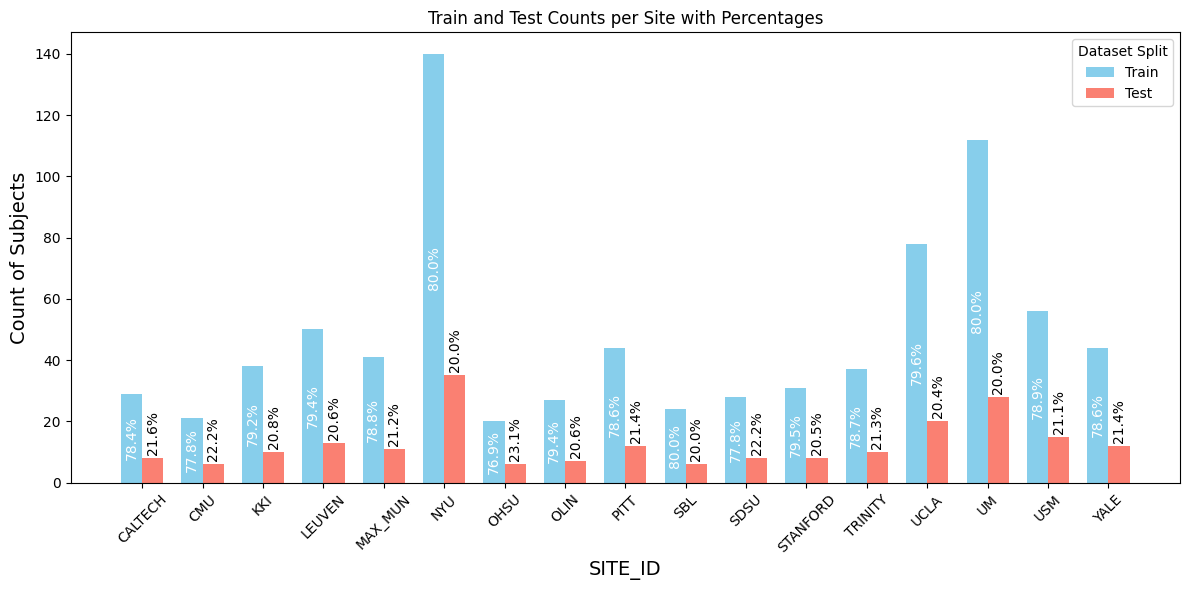

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Filtered DataFrame
filtered_df = subjects_df[
    (subjects_df['atlas'] == 'cc200') &
    (subjects_df['graph_feature_type'] == 'node_based') &
    (subjects_df['feature'] == 'degree') &
    (subjects_df['feature_engineering'] == 'original')
][['id', 'ASD', 'SITE_ID', 'SEX', 'AGE_AT_SCAN', 'test']]

# Calculate train and test counts per SITE_ID
site_counts = filtered_df.groupby(['SITE_ID', 'test']).size().unstack(fill_value=0)
site_counts.columns = ['train', 'test']
site_counts = site_counts.astype({"train": int, "test": int})

# Calculate percentages
site_counts_percent = site_counts.div(site_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(site_counts))  # X positions for each site

# Width of each bar
width = 0.35

# Plot bars for train and test with different colors
ax.bar([pos - width / 2 for pos in x], site_counts['train'], width=width, color='skyblue', label='Train')
ax.bar([pos + width / 2 for pos in x], site_counts['test'], width=width, color='salmon', label='Test')

# Adding percentage annotations
for idx, (site, counts) in enumerate(site_counts.iterrows()):
    # Train bar annotation in the middle
    train_count = counts['train']
    train_percent = site_counts_percent.loc[site, 'train'] # type: ignore
    ax.text(idx - width / 2, train_count / 2, f"{train_percent:.1f}%", ha='center', va='center', rotation=90, fontsize=10, color='white')

    # Test bar annotation at the top
    test_count = counts['test']
    test_percent = site_counts_percent.loc[site, 'test'] # type: ignore
    ax.text(idx + width / 2, test_count + 1, f"{test_percent:.1f}%", ha='center', va='bottom', rotation=90, fontsize=10, color='black')

# Adding titles and labels
plt.title("Train and Test Counts per Site with Percentages")
plt.xlabel("SITE_ID", fontsize=14)
plt.ylabel("Count of Subjects", fontsize=14)
plt.xticks(x, site_counts.index, rotation=45)  # type: ignore # Set x-ticks to site names
plt.legend(title='Dataset Split')

plt.tight_layout()
plt.show()

In [4]:
print(filtered_df.shape)
# Count the total number of train and test cases in filtered_df
train_test_counts = filtered_df['test'].value_counts()
train_test_counts

(1035, 6)


test
0    820
1    215
Name: count, dtype: int64

## 2. Model Training

In [5]:
subjects_df

,id,ASD,SITE_ID,SEX,AGE_AT_SCAN,atlas,graph_feature_type,feature,feature_engineering,features_value,test
0,51154,0,NYU,1,30.08,cc200,node_based,degree,original,"[15, 11, 6, 2, 7, 11, 6, 9, 0, 1, 7, 8, 4, 1, ...",0
1,50617,1,YALE,1,7.25,cc200,node_based,degree,original,"[22, 5, 5, 8, 14, 7, 12, 1, 3, 3, 11, 6, 8, 6,...",1
2,50807,1,KKI,1,10.65,cc200,node_based,degree,original,"[10, 15, 4, 15, 3, 7, 11, 5, 1, 2, 2, 12, 17, ...",0
3,51369,0,MAX_MUN,1,32.00,cc200,node_based,degree,original,"[3, 40, 29, 2, 15, 4, 10, 11, 0, 0, 6, 8, 22, ...",0
4,50135,1,OLIN,1,12.00,cc200,node_based,degree,original,"[18, 31, 23, 11, 8, 56, 45, 21, 7, 2, 3, 5, 44...",0
...,...,...,...,...,...,...,...,...,...,...,...
37255,50655,1,CMU,1,27.00,multi,graph_level,average_degree,pca_10,"[375.94, -146.53, -87.52, -1.93, -60.69, -25.5...",1
37256,50651,1,CMU,1,39.00,multi,graph_level,average_degree,pca_10,"[445.37, -319.32, 12.69, 6.62, -78.7, 27.38, 3...",1
37257,50664,0,CMU,1,21.00,multi,graph_level,average_degree,pca_10,"[-128.0, -61.37, -20.07, -27.63, -11.72, -3.33...",1
37258,50642,1,CMU,1,33.00,multi,graph_level,average_degree,pca_10,"[-210.26, -51.85, -42.6, -38.84, 9.02, -9.18, ...",1


### 2.1 Individual Site model training
A Family of Classifier Models for each individual Site

In [ ]:
from sklearn.exceptions import ConvergenceWarning
import warnings
from typing import List, Union
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

# Define the cases for feature engineering
cases = [
    {'graph_feature_type': 'node_based', 'feature': 'degree'},
    {'graph_feature_type': 'edge_based', 'feature': 'average_degree'},
    {'graph_feature_type': 'graph_level', 'feature': 'average_degree'}
]

# Define the models to try
models: List[
    Union[
        LogisticRegression
        , DecisionTreeClassifier
        , RandomForestClassifier
        , xgb.XGBClassifier
        , lgb.LGBMClassifier
        , SVC
        , MLPClassifier
    ]
] = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    xgb.XGBClassifier(),
    lgb.LGBMClassifier(verbose=-1),
    SVC(),
    MLPClassifier(),
]

model_names = {
    'LogisticRegression': 'LR',
    'DecisionTreeClassifier': 'DT',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB',
    'LGBMClassifier': 'LGBM',
    'SVC': 'SVM',
    'MLPClassifier': 'MLP'
}

# Initialize a list to store results
results = []

# Loop over each combination of parameters
for site_id in subjects_df['SITE_ID'].unique():
    for atlas in subjects_df['atlas'].unique():
        for case in cases:
            for fe in subjects_df['feature_engineering'].unique():
                # Filter the dataset for the specific combination of SITE_ID, atlas, case, and feature engineering
                subset_df = subjects_df[
                    (subjects_df['SITE_ID'] == site_id) &
                    (subjects_df['atlas'] == atlas) &
                    (subjects_df['graph_feature_type'] == case['graph_feature_type']) &
                    (subjects_df['feature'] == case['feature']) &
                    (subjects_df['feature_engineering'] == fe)
                ]

                # Skip if subset is empty
                if subset_df.empty:
                    continue

                # Extract features and labels
                X = np.stack(subset_df["features_value"].values)
                y = subset_df["ASD"].values

                # Train and evaluate each classifier
                for model in models:
                    model_name = model_names[type(model).__name__]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=ConvergenceWarning)  # Ignore only convergence warnings
                        # 10-fold cross-validation
                        cv_scores = cross_val_score(
                            estimator=model, # type: ignore
                            X=X,
                            y=y,
                            cv=10,  # Changed to 10 folds
                            scoring="accuracy",
                        )

                        # Get predicted values for additional metrics
                        y_pred = cross_val_predict(estimator=model, X=X, y=y, cv=10) # type: ignore

                        # Compute additional metrics
                        precision = precision_score(y, y_pred, average="weighted") * 100
                        recall = recall_score(y, y_pred, average="weighted") * 100
                        f1 = f1_score(y, y_pred, average="weighted") * 100

                        # Compute TN, FP, FN, TP using confusion matrix
                        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

                        # Compute Sensitivity (Recall for ASD = 1 (True Positive Rate))
                        sensitivity = (tp / (tp + fn)) * 100 if (tp + fn) != 0 else 0

                        # Compute Specificity (True Negative Rate)
                        specificity = (tn / (tn + fp)) * 100 if (tn + fp) != 0 else 0

                        # Store results
                        results.append(
                            {
                                "SITE_ID": site_id,
                                "atlas": atlas,
                                "graph_feature_type": case["graph_feature_type"],
                                "feature": case["feature"],
                                "feature_engineering": fe,
                                "model": model_name,
                                "cv_accuracy_mean": cv_scores.mean()
                                * 100,  # Accuracy in %
                                "cv_accuracy_std": cv_scores.std()
                                * 100,  # Accuracy std in %
                                "precision": precision,
                                "recall": recall,  # Weighted recall
                                "sensitivity": sensitivity,  # Recall for ASD=1 (TPR)
                                "specificity": specificity,  # True Negative Rate (TNR)
                                "f1_score": f1,
                            }
                        )

                        print(
                            f"Processed: {site_id}, {atlas}, {case['graph_feature_type']}, {fe}, {model_name}"
                        )

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the first few rows of results to verify
results_df.head()

- Sensitivity (True Positive Rate) → How well the model detects ASD cases.
- Specificity (True Negative Rate) → How well the model avoids misclassifying non-ASD cases.
- Both metrics should not be equal unless the dataset is perfectly balanced.
- A good model should balance high Sensitivity and Specificity.

In [26]:
results_df

,SITE_ID,atlas,graph_feature_type,feature,feature_engineering,model,cv_accuracy_mean,cv_accuracy_std,precision,recall,sensitivity,specificity,f1_score
0,NYU,cc200,node_based,degree,original,LR,56.045752,11.066085,56.381579,56.000000,52.000000,59.000000,56.145575
1,NYU,cc200,node_based,degree,original,DT,58.758170,8.470044,55.663750,56.571429,40.000000,69.000000,55.756695
2,NYU,cc200,node_based,degree,original,RF,64.084967,11.055657,55.065856,57.142857,22.666667,83.000000,52.728093
3,NYU,cc200,node_based,degree,original,XGB,62.941176,10.926181,62.241590,62.857143,45.333333,76.000000,61.938256
4,NYU,cc200,node_based,degree,original,LGBM,68.039216,9.533078,67.878788,68.000000,49.333333,82.000000,66.993007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,CMU,multi,graph_level,average_degree,pca_10,RF,56.666667,24.944383,51.994302,51.851852,50.000000,53.846154,51.851852
4280,CMU,multi,graph_level,average_degree,pca_10,XGB,56.666667,29.059326,55.925926,55.555556,50.000000,61.538462,55.433455
4281,CMU,multi,graph_level,average_degree,pca_10,LGBM,38.333333,7.637626,36.790123,37.037037,42.857143,30.769231,36.863346
4282,CMU,multi,graph_level,average_degree,pca_10,SVM,63.333333,22.110832,64.618736,62.962963,50.000000,76.923077,62.345679


## Overall performance for the whole dataset


In [28]:
# Group by SITE_ID and select the row with the best 'cv_accuracy_mean' for each SITE_ID
best_config_per_site = results_df.loc[
    results_df.groupby("SITE_ID")["cv_accuracy_mean"].idxmax()
]

# Get the size of data for each SITE_ID (the number of samples for each site)
unique_graph_feature_type = subjects_df["graph_feature_type"].nunique()
unique_feature_engineering = subjects_df["feature_engineering"].nunique()
unique_atlas = subjects_df["atlas"].nunique()

# Calculate the product of unique config values
product_of_unique_configs = (
    unique_graph_feature_type * unique_feature_engineering * unique_atlas
)

# Get the value_counts for SITE_ID
site_id_counts = subjects_df["SITE_ID"].value_counts()

# Divide the value_counts by the product of unique config values
site_sizes = (site_id_counts / product_of_unique_configs).astype(int)

# Merge the best configurations with the site sizes to get the weight for each SITE_ID
best_config_per_site = best_config_per_site.set_index("SITE_ID").join(site_sizes)

# Calculate the weighted average for each metric on the whole dataset
weighted_avg_accuracy = (
    best_config_per_site["cv_accuracy_mean"]
    * best_config_per_site.index.map(site_sizes)
).sum() / site_sizes.sum()


weighted_precision = (
    best_config_per_site["precision"] * best_config_per_site.index.map(site_sizes)
).sum() / site_sizes.sum()
weighted_recall = (
    best_config_per_site["recall"] * best_config_per_site.index.map(site_sizes)
).sum() / site_sizes.sum()
weighted_sensitivity = (
    best_config_per_site["sensitivity"] * best_config_per_site.index.map(site_sizes)
).sum() / site_sizes.sum()
weighted_specificity = (
    best_config_per_site["specificity"] * best_config_per_site.index.map(site_sizes)
).sum() / site_sizes.sum()
weighted_f1_score = (
    best_config_per_site["f1_score"] * best_config_per_site.index.map(site_sizes)
).sum() / site_sizes.sum()

# Print the weighted averages performance for the whole dataset
print(f"Weighted Average Accuracy for 10-fold CV: {weighted_avg_accuracy:.2f}%")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")
print(f"Weighted F1 Score: {weighted_f1_score:.4f}")

Weighted Average Accuracy for 10-fold CV: 75.25%
Weighted Precision: 75.3347
Weighted Recall: 75.0725
Weighted Sensitivity: 71.2001
Weighted Specificity: 76.4010
Weighted F1 Score: 74.6501


In [29]:
best_config_per_site

,atlas,graph_feature_type,feature,feature_engineering,model,cv_accuracy_mean,cv_accuracy_std,precision,recall,sensitivity,specificity,f1_score,count
SITE_ID,,,,,,,,,,,,,
CALTECH,multi,edge_based,average_degree,mi_10,DT,85.000000,16.583124,84.228935,83.783784,78.947368,88.888889,83.760076,37
CMU,cc200,node_based,degree,mi_10,RF,85.000000,18.929694,89.133089,88.888889,85.714286,92.307692,88.888889,27
KKI,multi,node_based,degree,mi_10,RF,81.500000,14.150972,83.461538,81.250000,60.000000,96.428571,80.303030,48
LEUVEN,dos160,node_based,degree,mi_10,RF,73.333333,13.834132,73.270248,73.015873,62.068966,82.352941,72.667151,63
MAX_MUN,cc200,node_based,degree,mi_10,RF,71.000000,17.000000,71.180432,71.153846,62.500000,78.571429,70.925684,52
NYU,cc200,node_based,degree,original,LGBM,68.039216,9.533078,67.878788,68.000000,49.333333,82.000000,66.993007,175
OHSU,multi,node_based,degree,mi_10,LR,91.666667,17.078251,92.307692,92.307692,91.666667,92.857143,92.307692,26
OLIN,aal,node_based,degree,mi_10,RF,85.833333,14.457793,82.568412,82.352941,89.473684,73.333333,82.163866,34
PITT,dos160,node_based,degree,mi_10,RF,72.666667,16.519349,71.729720,71.428571,79.310345,62.962963,71.207373,56


## Evaluations
Ablation study for evaluations of the different components of our `ASD-GraphNet` Framework on the four steps of our pipeline.
- Multi-Atlas vs. Single Atlas Analysis: We assess the impact of using multiple brain atlases versus single brain atlases on ASD detection performance.
- Graph Features Analysis: We investigate the contribution of various graph features to classification accuracy.
- Feature Engineering Analysis: We evaluate the effectiveness of mutual information-based feature selection and principal component analysis (PCA) in enhancing ASD detection.
- Binary ASD Classifier Analysis: We compare the performance of different classification models in discriminating ASD individuals from typically developing controls.

### Some Explorations on the results

1. Top five best performance pipeline

In [102]:
results_df.nlargest(5, "cv_accuracy_mean")

,SITE_ID,atlas,graph_feature_type,feature,feature_engineering,model,cv_accuracy_mean,cv_accuracy_std,precision,recall,sensitivity,specificity,f1_score
3976,OHSU,multi,node_based,degree,mi_10,LR,91.666667,17.078251,92.307692,92.307692,91.666667,92.857143,92.307692
3916,OHSU,dos160,node_based,degree,mi_10,XGB,88.333333,18.333333,90.497738,88.461538,75.000000,100.000000,88.195675
4041,CMU,cc200,node_based,degree,mi_10,RF,88.333333,18.333333,89.133089,88.888889,85.714286,92.307692,88.888889
3286,SBL,cc200,node_based,degree,mi_10,XGB,86.666667,22.110832,86.666667,86.666667,86.666667,86.666667,86.666667
4230,CMU,multi,node_based,degree,mi_10,RF,86.666667,20.816660,85.900673,85.185185,92.857143,76.923077,85.061728


2. Top five best performance pipeline for `NYU` SITE ID.

In [66]:
results_df[results_df["SITE_ID"] == "UM"].nlargest(5, "cv_accuracy_mean")

,SITE_ID,atlas,graph_feature_type,feature,feature_engineering,model,cv_accuracy_mean,cv_accuracy_std,precision,recall,sensitivity,specificity,f1_score
2653,UM,dos160,node_based,degree,mi_10,LR,67.857143,7.319251,67.810761,67.857143,63.636364,71.621622,67.802689
2531,UM,cc200,node_based,degree,mi_10,LGBM,66.428571,6.428571,66.404396,66.428571,63.636364,68.918919,66.413092
2659,UM,dos160,node_based,degree,mi_10,MLP,66.428571,9.063270,65.695062,65.714286,57.575758,72.972973,65.487416
2761,UM,multi,graph_level,average_degree,mi_10,XGB,66.428571,15.987878,66.459386,66.428571,65.151515,67.567568,66.440591
2658,UM,dos160,node_based,degree,mi_10,SVM,65.714286,10.973065,66.308230,65.714286,50.000000,79.729730,64.866383


3. Comparing the results of different `atlas` based on F1 Score and maximum achieved performance for all the individual sites.

In [35]:
results_df.groupby("atlas")["f1_score"].max().sort_values(ascending=False)

atlas
multi     92.307692
cc200     88.888889
dos160    88.195675
aal       85.015144
Name: f1_score, dtype: float64

4. Comparing the results of each individual recording center `SITE_ID` when using different `atlas`

In [25]:
results_df.groupby(["SITE_ID", "atlas"])["f1_score"].max().unstack()

atlas,aal,cc200,dos160,multi
SITE_ID,,,,
CALTECH,75.640036,78.378378,83.760076,83.760076
CMU,70.370370,88.888889,70.288970,88.858238
KKI,70.833333,69.671094,70.833333,82.669197
LEUVEN,71.471861,68.253968,72.423280,71.428571
MAX_MUN,59.660340,67.246676,66.333125,72.456576
NYU,56.755903,68.089054,61.424566,66.622778
OHSU,84.428904,80.682736,88.195675,92.307692
OLIN,85.015144,79.320747,85.015144,76.470588
PITT,67.857143,71.355311,67.010164,69.497236


5. Compare the results of each `atlas` when using different graph features

In [37]:
results_df.groupby(["atlas", "graph_feature_type"])["f1_score"].max().unstack()

graph_feature_type,edge_based,graph_level,node_based
atlas,,,
aal,81.908169,72.569444,85.015144
cc200,78.378378,74.325236,88.888889
dos160,72.569444,73.412389,88.195675
multi,84.615385,80.997921,92.307692


6. Compare the results of each `atlas` when using different feature engineering techniques

In [38]:
results_df.groupby(["atlas", "feature_engineering"])["f1_score"].max().unstack()

feature_engineering,mi_10,original,pca_10
atlas,,,
aal,85.015144,79.192488,81.908169
cc200,88.888889,76.923077,80.682736
dos160,88.195675,76.643357,73.412389
multi,92.307692,84.615385,84.615385


7. Compare the results of each `atlas` when using different `classifiers`

In [39]:
results_df.groupby(["atlas", "model"])["f1_score"].max().unstack()

model,DT,LGBM,LR,MLP,RF,SVM,XGB
atlas,,,,,,,
aal,80.816136,72.721624,75.670236,80.682736,85.015144,82.947888,81.908169
cc200,78.378378,70.076378,81.481481,80.682736,88.888889,78.378378,86.666667
dos160,76.923077,72.228665,76.643357,85.015144,84.428904,84.428904,88.195675
multi,83.760076,74.773140,92.307692,83.760076,88.858238,78.378378,82.978723


8. Average Performance:

Calculate the maximum Accuracies and F1 Score for each atlas across all sites, graph features, feature engineering methods, and classifier models.

Compare the mean accuracies of each atlas. The atlas with the highest mean accuracy is generally considered the best performer

In [88]:
results_df.groupby("atlas").agg(
    {"cv_accuracy_mean": "max", "f1_score": "max", 'precision': "max"}
).reset_index()

,atlas,cv_accuracy_mean,f1_score,precision,recall
0,aal,88.333333,85.015144,86.163102,85.294118
1,cc200,86.666667,88.888889,89.133089,88.888889
2,dos160,88.333333,88.195675,90.497738,88.461538
3,multi,91.666667,92.307692,92.307692,92.307692


9. Paired T-Tests:

Perform paired t-tests to compare the max accuracies of each atlas pair.

Statistical Significance: Examine the p-values from the paired t-tests. If p < 0.05, there's a significant difference between the atlases being compared. This helps determine if the performance difference is statistically meaningful

In [47]:
from scipy import stats

atlases = ["cc200", "aal", "dos160", "multi"]
p_values = []

for i in range(len(atlases)):
    for j in range(i + 1, len(atlases)):
        atlas1 = results_df[results_df["atlas"] == atlases[i]]["f1_score"]
        atlas2 = results_df[results_df["atlas"] == atlases[j]]["f1_score"]
        t_stat, p_val = stats.ttest_rel(atlas1, atlas2)
        p_values.append((atlases[i], atlases[j], p_val))

p_value_df = pd.DataFrame(p_values, columns=["Atlas1", "Atlas2", "P-value"])
p_value_df["Statistical Significance"] = p_value_df["P-value"] < 0.05
p_value_df

,Atlas1,Atlas2,P-value,Statistical Significance
0,cc200,aal,6.259307e-08,True
1,cc200,dos160,2.502432e-01,False
2,cc200,multi,1.367292e-02,True
3,aal,dos160,4.567416e-05,True
4,aal,multi,4.433025e-16,True
5,dos160,multi,3.354464e-04,True
